# Traj-XAI Basic Example

This notebook demonstrates the basic usage of the Traj-XAI package for explaining trajectory classifications.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

First, let's import the necessary libraries:


In [2]:
# Install required packages if needed
!pip install rdp fastdtw pactus

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4585 sha256=386fecac6f21dde7d75efd7b3a1459eb857cac20929f134cfcd980ab47eb9397
  Stored in directory: /root/.cache/pip/wheels/40/25/67/b7065f31a9d5388f822ed08341da456e2dd047a1dbae2cf62a
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542089 sha256=6b1d99d4a31f84d7fceae691ba9eb4bbf8327c4b7aa4409386153e7050f7a3e1
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built rdp fastdtw


In [3]:
import sys
sys.path.append('/content/traj_xai')

In [4]:
!cp -r '/content/drive/MyDrive/[NCKH]_Trajectory_Data_Mining/traj_xai' '/content/traj_xai'

In [5]:
import numpy as np
from pactus import Dataset
from pactus.models import LSTMModel
import matplotlib.pyplot as plt

# Import from our traj-xai package
from traj_xai.src import rdp_segmentation, gaussian_perturbation, TrajectoryManipulator

## Load and Prepare Data


In [6]:
# Set a random seed for reproducibility
SEED = 0

# Load the UCI Movement Libras dataset
dataset = Dataset.uci_movement_libras()
print(f"Dataset loaded: {len(dataset.trajs)} trajectories")

# Split data into train and test subsets
train, test = dataset.split(0.8, random_state=SEED)
print(f"Train set: {len(train.trajs)} trajectories")
print(f"Test set: {len(test.trajs)} trajectories")

[==================================================] 100.00%
Dataset loaded: 360 trajectories
Train set: 288 trajectories
Test set: 72 trajectories


## Train a Black Box Model


In [7]:
# Build and train the model
model = LSTMModel(random_state=SEED)

# Train the model on the train dataset (with fewer epochs for demo)
model.train(train, dataset, epochs=5, batch_size=64)

# Evaluate the model on the test dataset
evaluation = model.evaluate(test)
evaluation.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.0616 - loss: 2.7158
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.0577 - loss: 2.7219
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.0510 - loss: 2.7168
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.0786 - loss: 2.7111
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.0440 - loss: 2.7101
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step

General statistics:

Accuracy: 0.056
F1-score: 0.007
Mean precision: 0.004
Mean recall: 0.067

Confusion matrix:

anti-clockwise arc        circle                    clockwise arc             curved swing              face-down curve           face-up curve             horizontal straight-line  horizontal swing          horizontal wavy           horizontal zigzag         tremble                   vertical straight-line    vertical swing            vertical wavy             vertical zigzag           precision                 
0.0                       0.0                       0.0                       0.0                       0.0

## Visualize a Sample Trajectory


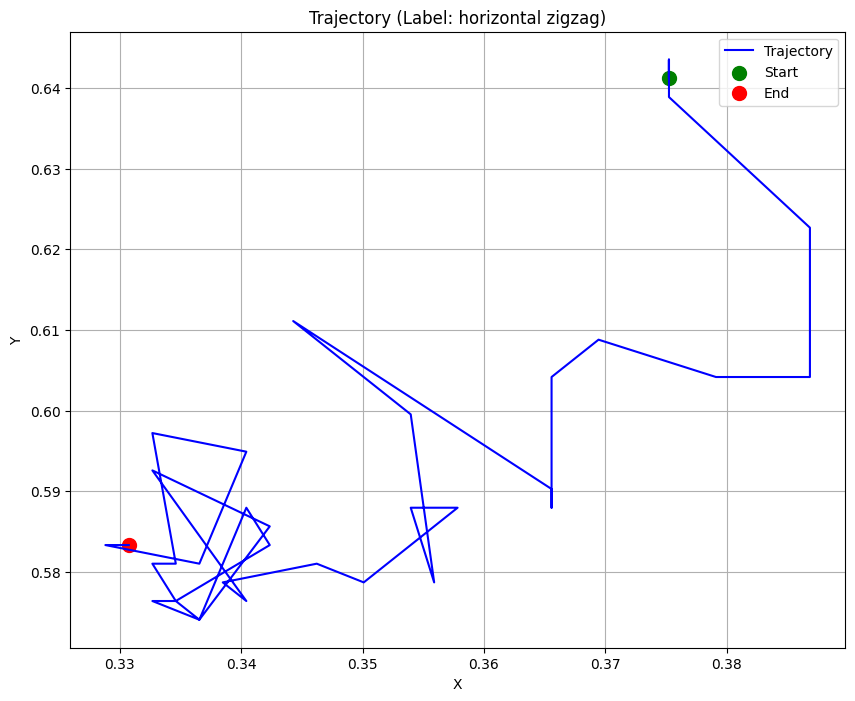

In [8]:
# Get a sample trajectory
sample_idx = 0
sample_traj = test.trajs[sample_idx]
sample_label = test.labels[sample_idx]

# Extract coordinates for plotting
points = sample_traj.r
x = [p[0] for p in points]
y = [p[1] for p in points]

# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(x, y, "b-", label="Trajectory")
plt.scatter(x[0], y[0], c="green", s=100, label="Start")
plt.scatter(x[-1], y[-1], c="red", s=100, label="End")
plt.title(f"Trajectory (Label: {sample_label})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Segment the Trajectory


Number of segments: 18


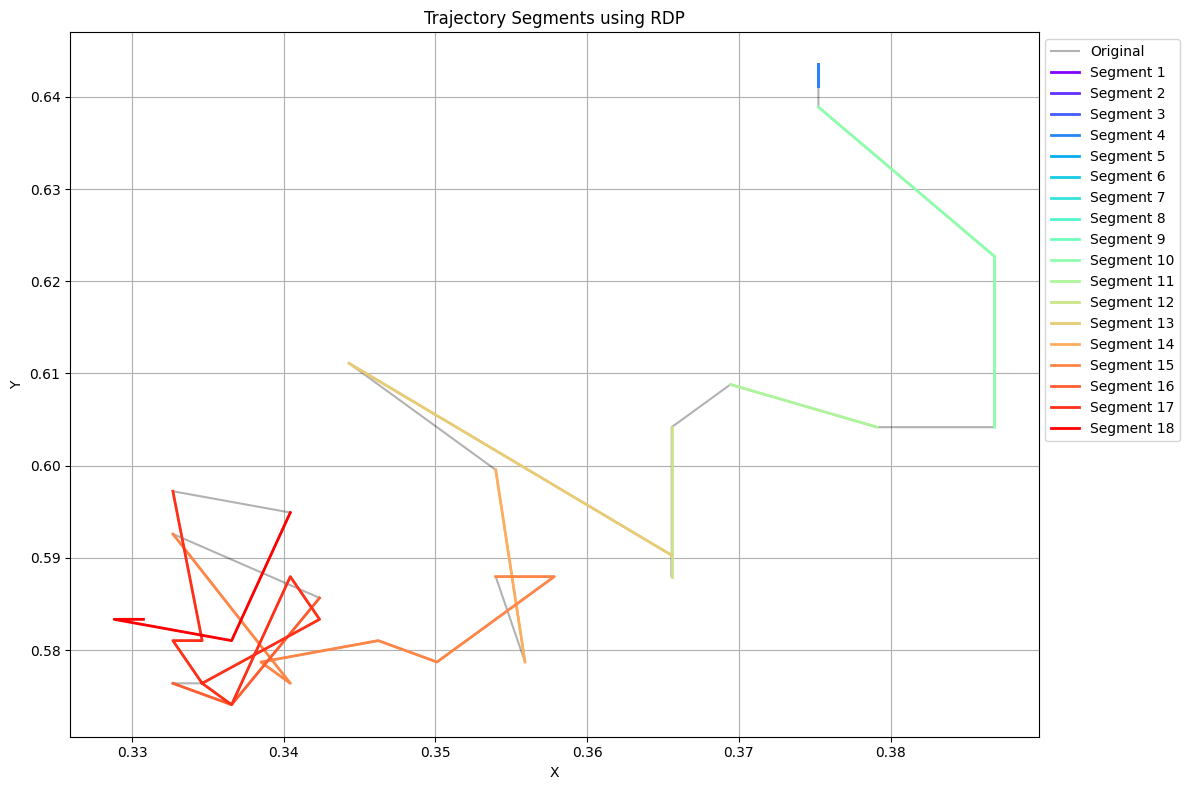

In [9]:
# Apply RDP segmentation
segments = rdp_segmentation(points, epsilon=0.01)
print(f"Number of segments: {len(segments)}")

# Plot the original trajectory and the segments
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, label="Original")

# Plot each segment with a different color
colors = plt.cm.rainbow(np.linspace(0, 1, len(segments)))
for i, segment in enumerate(segments):
    segment_x = [p[0] for p in segment]
    segment_y = [p[1] for p in segment]
    plt.plot(
        segment_x, segment_y, "-", color=colors[i], linewidth=2, label=f"Segment {i+1}"
    )

plt.title("Trajectory Segments using RDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Perturb One Segment


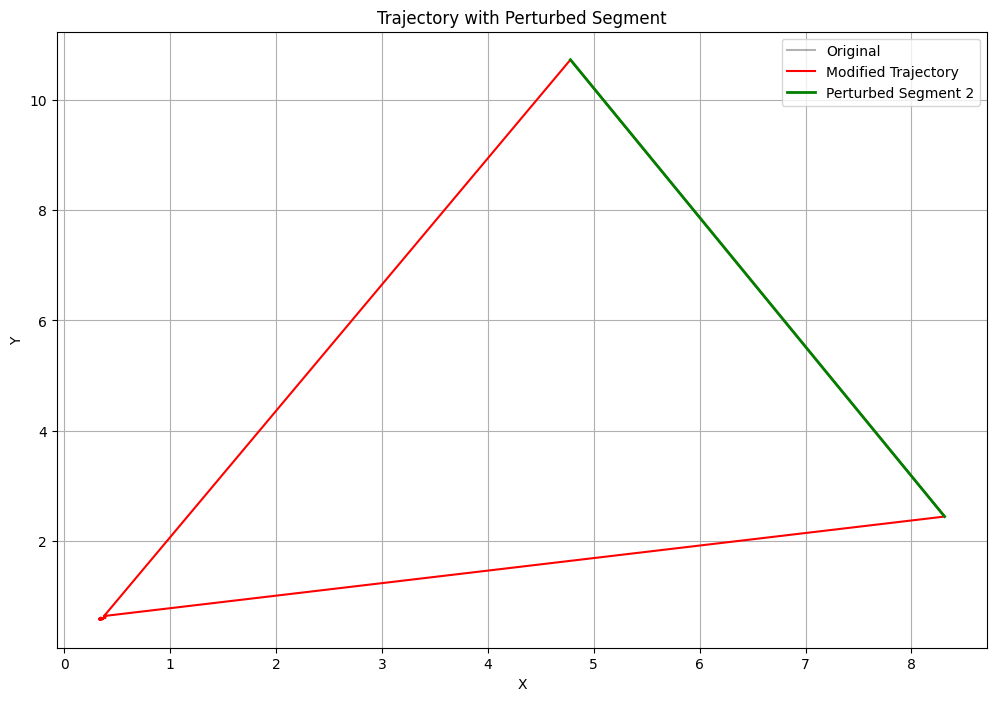

In [10]:
# Apply Gaussian perturbation to one segment
segment_to_perturb = 1  # Choose which segment to perturb
perturbed_segment = gaussian_perturbation(segments[segment_to_perturb])

# Visualize the perturbation
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, label="Original")

# Create a modified trajectory by replacing the perturbed segment
modified_segments = segments.copy()
modified_segments[segment_to_perturb] = perturbed_segment
modified_trajectory = []
for segment in modified_segments:
    modified_trajectory.extend(segment)

# Plot modified trajectory
modified_x = [p[0] for p in modified_trajectory]
modified_y = [p[1] for p in modified_trajectory]
plt.plot(modified_x, modified_y, "r-", label="Modified Trajectory")

# Highlight the perturbed segment
perturbed_x = [p[0] for p in perturbed_segment]
perturbed_y = [p[1] for p in perturbed_segment]
plt.plot(
    perturbed_x,
    perturbed_y,
    "g-",
    linewidth=2,
    label=f"Perturbed Segment {segment_to_perturb+1}",
)

plt.title("Trajectory with Perturbed Segment")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Generate Explanation


In [14]:
# Create a TrajectoryManipulator for the sample trajectory
trajectory_explainer = TrajectoryManipulator(
    points, rdp_segmentation, gaussian_perturbation, model
)

# Get segments
segments = trajectory_explainer.get_segment()
print(f"Number of segments: {len(segments)}")

# Generate explanation
coef = trajectory_explainer.explain()
print(f"\nExplanation coefficients: {coef}")

if coef is not None:
    # Get the absolute values of coefficients for importance
    if len(coef.shape) > 1 and coef.shape[0] > 1:
        # For multi-class, take the row corresponding to the predicted class
        y = trajectory_explainer.get_Y()[0]
        class_index = np.where(trajectory_explainer.classes_ == y)[0][0]
        importances = np.abs(coef[class_index])
    else:
        importances = np.abs(coef[0])

    # Visualize segment importance
    plt.figure(figsize=(12, 8))

    # Plot the original trajectory
    plt.plot(x, y, "k-", alpha=0.3)

    # Plot each segment with color intensity based on importance
    normalized_importances = importances / importances.max()

    for i, segment in enumerate(segments):
        segment_x = [p[0] for p in segment]
        segment_y = [p[1] for p in segment]

        # Use red for positive influence, stronger color for higher importance
        color_intensity = normalized_importances[i]
        plt.plot(
            segment_x,
            segment_y,
            "-",
            color=(1.0, 0.0, 0.0, color_intensity),
            linewidth=2 + 3 * color_intensity,
        )

        # Add a text label for the segment importance
        mid_point = len(segment) // 2
        plt.text(
            segment_x[mid_point],
            segment_y[mid_point],
            f"{importances[i]:.2f}",
            fontweight="bold",
            ha="center",
            va="bottom",
        )

    plt.title("Segment Importance for Classification")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


Number of segments: 28
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Explanation coefficients: None


## Evaluate the Effect of Perturbations


In [16]:
# Get predictions for evaluation trajectories
y_eval_sorted = trajectory_explainer.get_Y_eval_sorted()
print("Predictions for evaluation trajectories (sorted by importance):")
for i, pred in enumerate(y_eval_sorted):
    print(f"Segment {i+1}: {pred}")

# Get the original prediction
original_pred = trajectory_explainer.get_Y()
print(f"\nOriginal trajectory prediction: {original_pred}")

# Check if any segments change the classification when perturbed
changed_segments = []
for i, pred in enumerate(y_eval_sorted):
    if not np.allclose(pred, original_pred):  # Check if predictions differ
        changed_segments.append(i)

print(f"\nSegments that changed classification when perturbed: {changed_segments}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Error in get_Y_eval_sorted: 'TrajectoryManipulator' object has no attribute 'classes_'
Predictions for evaluation trajectories (sorted by importance):
Segment 1: 0.0
Segment 2: 0.0
Segment 3: 0.0
Segment 4: 0.0
Segment 5: 0.0
Segment 6: 0.0
Segment 7: 0.0
Segment 8: 0.0
Segment 9: 0.0
Segment 10: 0.0
Segment 11: 0.0
Segment 12: 0.0
Segment 13: 0.0
Segment 14: 0.0
Segment 15: 0.0
Segment 16: 0.0
Segment 17: 0.0
Segment 18: 0.0
Segment 19: 0.0
Segment 20: 0.0
Segment 21: 0.0
Segment 22: 0.0
Segment 23: 0.0
Segment 24: 0.0
Segment 25: 0.0
Segment 26: 0.0
Segment 27: 0.0
Segment 28: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Original trajectory prediction: [[0.06340735 0.06767581 0.06566037 0.07004349 0.06769649 0.06861461
  0.06909726 0.06399587 0.07027573 0.06889813 0.06246291 0.0659076
  0.06556299 0.06756058 0.06314079]]

Segments that changed classification when perturbed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 